In [1]:
!pip install lazypredict -q > /dev/null

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, recall_score
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss
import numpy as np
import seaborn as sns

#Preparación de datos
## Extracción del archivo tratado


In [3]:
url = "https://raw.githubusercontent.com/Juanmeve837/TelecomXAlura/main/df_v3.csv"
df_v3 = pd.read_csv(url)

#Diccionario de datos

* customerID: número de identificación único de cada cliente
* Churn: si el cliente dejó o no la empresa
* gender: género (masculino y femenino)
* SeniorCitizen: información sobre si un cliente tiene o no una edad igual o mayor a 65 años
* Partner: si el cliente tiene o no una pareja
* Dependents: si el cliente tiene o no dependientes
* tenure: meses de contrato del cliente
* PhoneService: suscripción al servicio telefónico
* MultipleLines: suscripción a más de una línea telefónica
* InternetService: suscripción a un proveedor de internet
* OnlineSecurity: suscripción adicional de seguridad en línea
* OnlineBackup: suscripción adicional de respaldo en línea
* DeviceProtection: suscripción adicional de protección del dispositivo
* TechSupport: suscripción adicional de soporte técnico, menor tiempo de espera
* StreamingTV: suscripción de televisión por cable
* StreamingMovies: suscripción de streaming de películas
* Contract: tipo de contrato
* PaperlessBilling: si el cliente prefiere recibir la factura en línea
* PaymentMethod: forma de pago
* Charges.Monthly: total de todos los servicios del cliente por mes
* Charges.Total: total gastado por el cliente

## Elimininacion de columnas irrelevantes


In [4]:
df = df_v3.drop(['customerID'], axis=1)

In [5]:
bool_cols = df.select_dtypes(include=bool).columns
df[bool_cols] = df[bool_cols].astype(int)

## Verificación de la proporción de cancelación (churn)


Churn
0   0.73
1   0.27
Name: proportion, dtype: float64


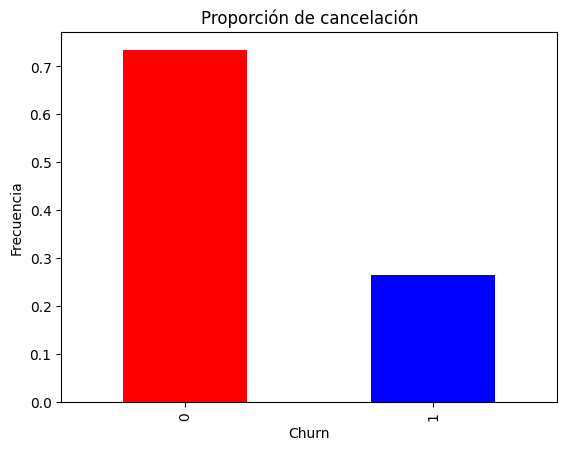

In [6]:
propor = df['Churn'].value_counts(normalize=True)

print(propor)

propor.plot(kind="bar", color=['red', 'blue'])
plt.xlabel("Churn")
plt.ylabel("Frecuencia")
plt.title("Proporción de cancelación")
plt.show()

In [7]:
cols_replace = ["gender","MultipleLines", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
df[cols_replace] = df[cols_replace].replace({'Yes': 1, 'No': 0, "Female": 1, "Male":0, "No phone service": 0, 'No internet service': 0}).infer_objects(copy=False).astype(int)

## Normalización y/o Estandarización


In [8]:
columnas_normalizar = ["tenure", "Charges.Monthly", "Charges.Total"]

scaler = MinMaxScaler()
df[columnas_normalizar] = scaler.fit_transform(df[columnas_normalizar])

In [9]:
columnas_a_codificar = ["InternetService", "Contract", "PaymentMethod"]
encoder = OneHotEncoder()
encoded_array = encoder.fit_transform(df[columnas_a_codificar].astype(str))

## Encoding

In [10]:
encoded_df = pd.DataFrame(encoded_array.toarray(), columns=encoder.get_feature_names_out(columnas_a_codificar))

df_encoded = pd.concat([df.drop(columns=columnas_a_codificar), encoded_df], axis=1)

# Correlación y Selección de variables




In [11]:
df_encoded.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,1,0.12,1,0,0,1,...,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
1,0,0,0,0,0,0.12,1,1,0,0,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2,1,0,0,0,0,0.06,1,0,0,0,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
3,1,0,1,1,0,0.18,1,0,0,1,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
4,1,1,1,1,0,0.04,1,0,0,0,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00


## Analisis de Correlación


In [12]:
corr = df_encoded.corr()
corr["Churn"].sort_values(ascending=False)

,Churn
Churn,1.00
Contract_Month-to-month,0.41
InternetService_Fiber optic,0.31
PaymentMethod_Electronic check,0.30
Charges.Monthly,0.19
PaperlessBilling,0.19
SeniorCitizen,0.15
StreamingTV,0.06
StreamingMovies,0.06
MultipleLines,0.04


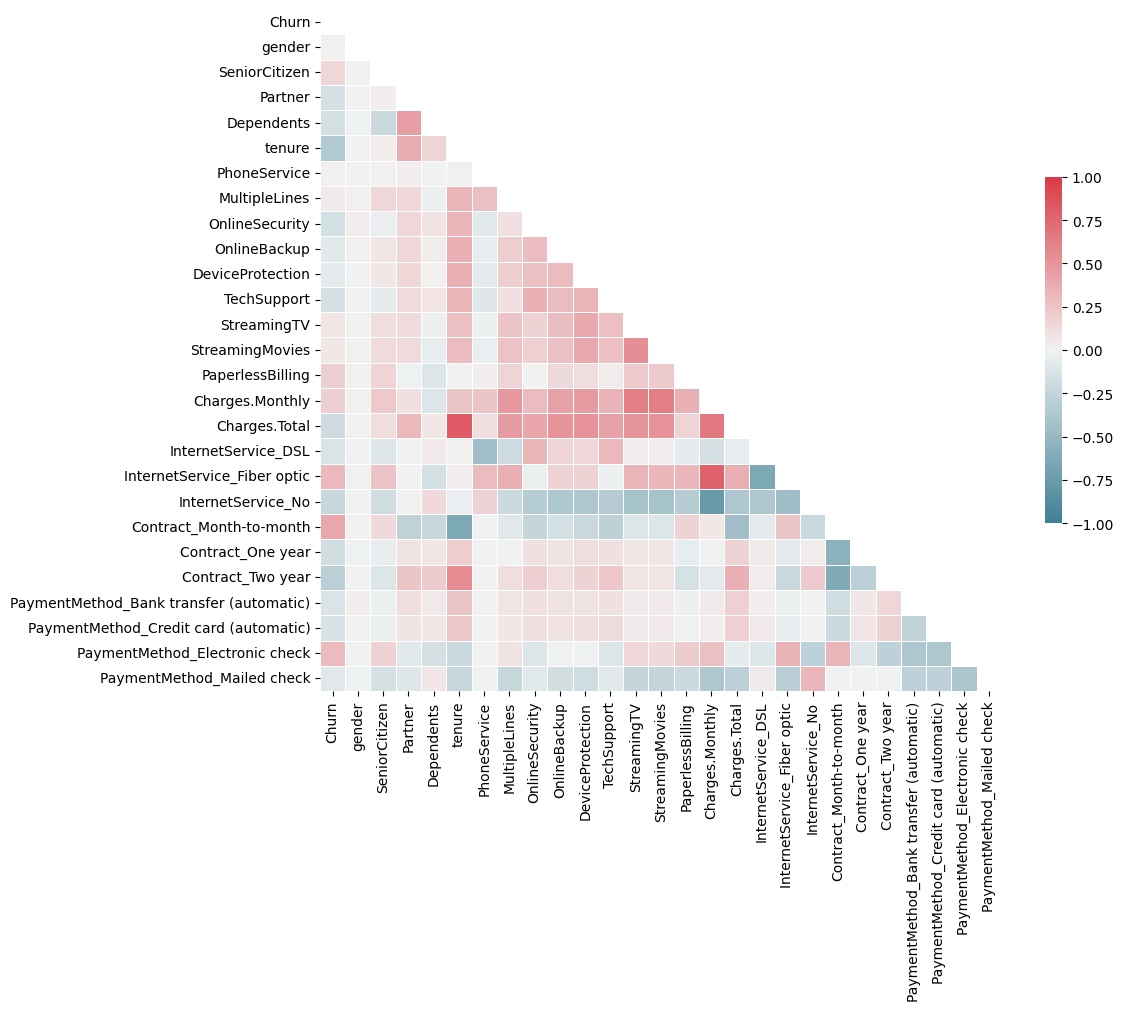

In [13]:
mascara = np.zeros_like(corr, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mascara, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


plt.show()

## Analisis Dirigido


In [14]:
def corr_dirigida(df, col_box, col_obj):

    plt.figure(figsize=(8, 5))

    sns.boxplot(data=df, hue=col_obj, x=col_box, orient="h", width=0.4, gap=0.2)
    plt.title(f"Distribución de {col_box}", fontsize=14, fontweight="bold")
    plt.ylabel(col_obj, fontsize=12)
    plt.xlabel(col_box, fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

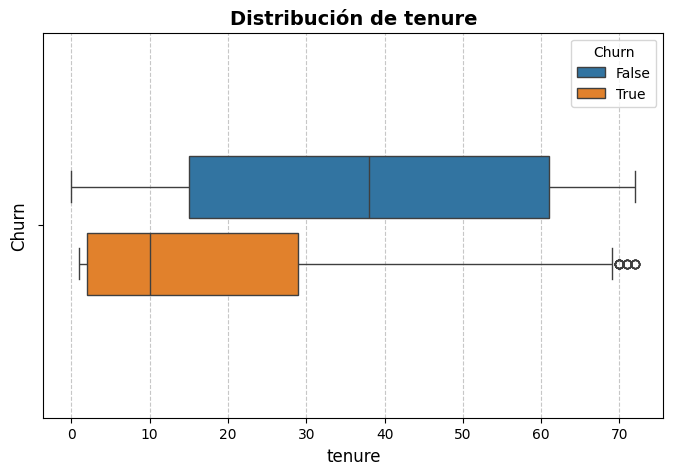

In [15]:
corr_dirigida(df_v3, "tenure", "Churn")

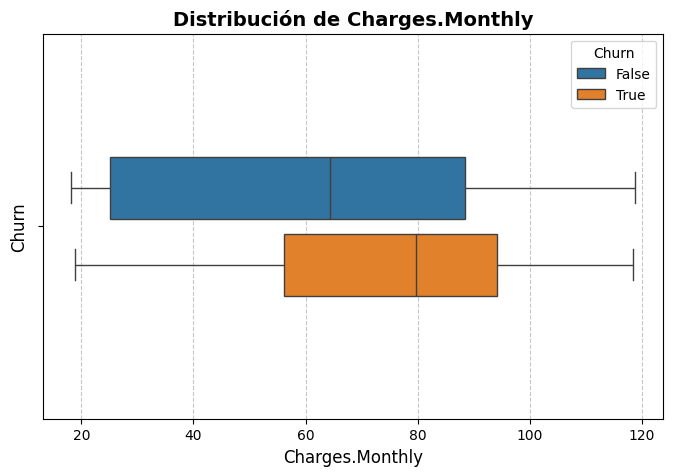

In [16]:
corr_dirigida(df_v3, "Charges.Monthly", "Churn")

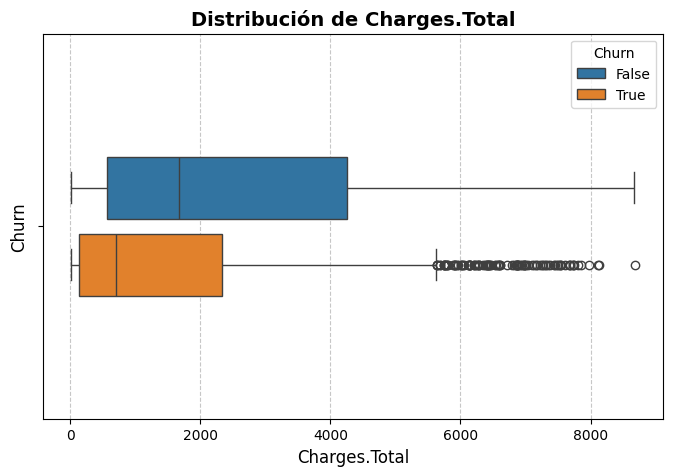

In [17]:
corr_dirigida(df_v3, "Charges.Total", "Churn")

## Separación de Datos


In [18]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

## Creación de Modelos

In [19]:
# analisis sin balancear "Churn"
X_train, X_test, y_train, y_test = train_test_split(X, y.values,test_size=.5,random_state =123)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 910, number of negative: 2611
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 3521, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258449 -> initscore=-1.054044
[LightGBM] [Info] Start training from score -1.054044


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
GaussianNB,0.75,0.76,0.76,0.76,0.02
NearestCentroid,0.74,0.76,0.76,0.76,0.04
BernoulliNB,0.77,0.75,0.75,0.78,0.07
QuadraticDiscriminantAnalysis,0.73,0.74,0.74,0.75,0.05
PassiveAggressiveClassifier,0.76,0.73,0.73,0.76,0.03
LogisticRegression,0.80,0.72,0.72,0.80,0.05
LinearDiscriminantAnalysis,0.80,0.72,0.72,0.79,0.06
AdaBoostClassifier,0.80,0.71,0.71,0.79,0.32
LinearSVC,0.80,0.71,0.71,0.79,0.06



## Evaluación de Modelos

In [20]:
#Elección de modelos:

# 1- LogisticRegression
model_dictionary = clf.provide_models(X_train, X_test, y_train, y_test)
log_reg = model_dictionary["LogisticRegression"]

# 1- linearSVC
linearSVC = model_dictionary["LinearSVC"]

In [21]:
def intervalo_confianza(scores, confianza=0.95):
    media = np.mean(scores)
    dst = np.std(scores)
    return f'El intervalo de confianza es: {media - dst * confianza:0.3f} - {media + dst * confianza:0.3f}'

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(recall_score, average="weighted")
scores = cross_val_score(log_reg, X, y, cv=kf, scoring=scorer)
intervalo_confianza(scores)


'El intervalo de confianza es: 0.797 - 0.813'

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(recall_score, average="weighted")
scores = cross_val_score(linearSVC, X, y, cv=kf, scoring=scorer)
intervalo_confianza(scores)

'El intervalo de confianza es: 0.797 - 0.811'

## Balanceo de clases (datos balanceados y no balanceados)


In [24]:
pipeline1 = Pipeline([
    ("undersample", NearMiss(version=3)),
    ("model1", log_reg)
    ])
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline1, X, y, cv=kf, scoring=scorer)
intervalo_confianza(scores)

'El intervalo de confianza es: 0.764 - 0.780'

In [25]:
pipeline2 = Pipeline([
    ("undersample", NearMiss(version=3)),
    ("model2", linearSVC)
    ])
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline2, X, y, cv=kf, scoring=scorer)
intervalo_confianza(scores)

'El intervalo de confianza es: 0.761 - 0.777'

# Interpretación y Conclusiones
## Análisis de la importancia de las variables


In [26]:
coeficientes1 = pd.DataFrame({
    "Variable": X.columns,
    "Coeficiente": pipeline1.named_steps['model1'].named_steps['classifier'].coef_[0]}).sort_values(by="Coeficiente", ascending=False)

In [27]:
coeficientes1

,Variable,Coeficiente
15,Charges.Total,0.52
17,InternetService_Fiber optic,0.43
19,Contract_Month-to-month,0.27
12,StreamingMovies,0.14
6,MultipleLines,0.13
24,PaymentMethod_Electronic check,0.12
11,StreamingTV,0.11
13,PaperlessBilling,0.09
1,SeniorCitizen,0.09
2,Partner,0.03


In [28]:
coeficientes2 = pd.DataFrame({
    "Variable": X.columns,
    "Coeficiente": pipeline2.named_steps['model2'].named_steps['classifier'].coef_[0]}).sort_values(by="Coeficiente", ascending=False)

In [29]:
coeficientes2

,Variable,Coeficiente
17,InternetService_Fiber optic,0.23
12,StreamingMovies,0.08
11,StreamingTV,0.07
6,MultipleLines,0.07
24,PaymentMethod_Electronic check,0.05
19,Contract_Month-to-month,0.05
1,SeniorCitizen,0.04
13,PaperlessBilling,0.03
5,PhoneService,0.01
9,DeviceProtection,0.01


## Conclusión


1.	Proporción: la proporción de “churn” de las personas que han abandonado el servicio es del 27%, como lo que buscamos predecir cuales son los usuarios que abandonan o abandonaran el servicio considero que no es un mal punto de partida, ya que necesitamos identificar los factores que mas inciden en la permanencia en la empresa, sin embargo, en la última sección de realizó un balance de los datos para comparar si aporta o no a la exactitud del modelo
2.	Con respecto al análisis de correlación se puede concluir que factores como el tipo de contrato sea mes a mes, el servicio de internet por fibra óptica y el pago mediante cheque virtual influyen negativamente a la permanencia del usuario, al respecto se tiene algunas hipótesis.
a.	Contrato mes a mes, no genera una relación de dependencia con la compañía por lo que los usuarios deben estar prestos a cambiar o abandonar el servicio.
b.	El servicio de internet por fibra óptica deber tener prestaciones malas o por debajo de los servicios de la competencia.
c.	El pago por medio de cheque virtual al ser un pago no automático debe influir en la psicología del usuario.
3.	Contrario los factores que mas influyen en si un usuario permanece o no; es el “tiempo de permanencia” (Tenure), si cuenta con contrato de 2 años, y si tienen el servicio de internet.
4.	Para el análisis se pondrá especial énfasis en el “Recall” como métrica principal, ya que necesitamos identificar si un usuario es candidato a cancelación del servició.
5.	Los modelos escogidos fueron el LogisticRegression y LineaSVC , ya que ofrecieron resultados de Recall altos, fueron rápidos y de fácil interpretación en términos de entender que variables contribuyen mas al modelo.
6.	En general ambos modelos concluyen que las variables que mas contribuyen a la salida de un usuario son: cargos totales, internet de fibra óptica, contrato mes a mes, permanencia, servicio de internet y contrato a 2 años son los que mas influyen en la decisión, sin embargo conceptos como streaming también van escalando en importancia.  


